In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2022-05-03 17:57:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   125MB/s    in 1.1s    

2022-05-03 17:57:56 (125 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2022-05-03 17:57:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#https://medium.datadriveninvestor.com/horse-or-human-image-classification-c98b9dc94f6f
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip)
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [3]:
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

valid_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')
valid_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')
print('The total number of horse images for training : ', len(os.listdir(train_horse_dir)))
print('The total number of human images for training : ', len(os.listdir(train_human_dir)))
print('The total number of horse images for validation : ', len(os.listdir(valid_horse_dir)))
print('The total number of human images for validation : ', len(os.listdir(valid_human_dir)))

The total number of horse images for training :  500
The total number of human images for training :  527
The total number of horse images for validation :  128
The total number of human images for validation :  128


In [4]:
import tensorflow as tf

model = tf.keras.Sequential([# First Convolution layer
                             tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu, input_shape=(300, 300, 3)),
                             tf.keras.layers.MaxPool2D(2, 2),
                             # Second Convolution layer
                             tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu),
                             tf.keras.layers.MaxPool2D(2, 2),
                             # Third Convolution layer
                             tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
                             tf.keras.layers.MaxPool2D(2, 2),
                             # Fourth Convolution layer
                             tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
                             tf.keras.layers.MaxPool2D(2, 2),
                             # Fifth Convolution layer
                             tf.keras.layers.Conv2D(64, (3, 3), activation=tf.nn.relu),
                             tf.keras.layers.MaxPool2D(2, 2),
                             # Flatten and feed into DNN
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation=tf.nn.relu),
                             tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

['horse41-8.png', 'horse45-1.png', 'horse40-4.png', 'horse31-5.png', 'horse30-7.png', 'horse42-1.png', 'horse42-5.png', 'horse38-7.png', 'horse20-7.png', 'horse08-6.png']
['human07-28.png', 'human02-06.png', 'human15-24.png', 'human12-30.png', 'human06-01.png', 'human08-17.png', 'human07-01.png', 'human15-07.png', 'human05-23.png', 'human05-13.png']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


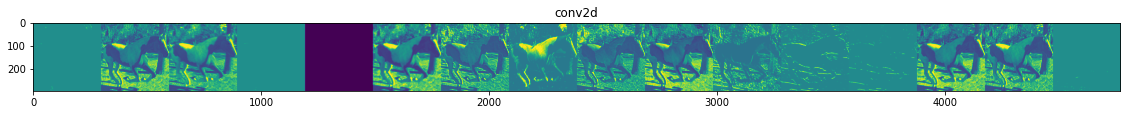

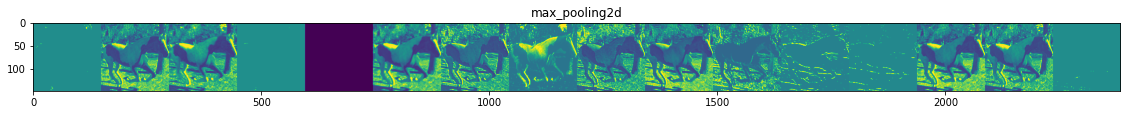

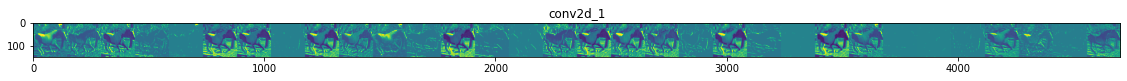

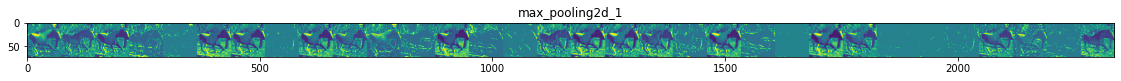

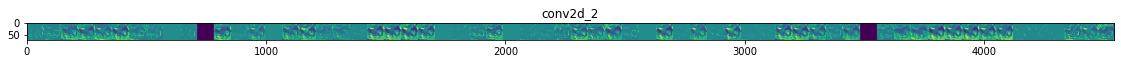

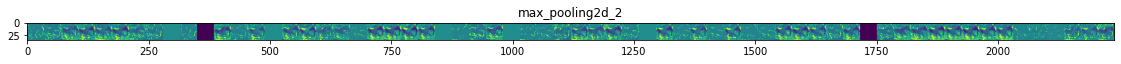

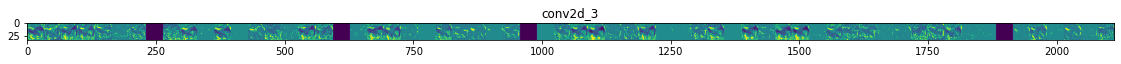

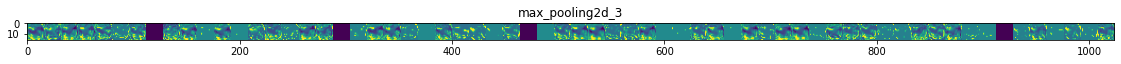

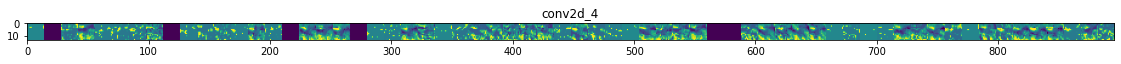

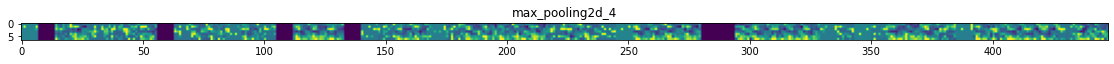

In [5]:
import numpy as np
import random
from tensorflow.keras.preprocessing import image

train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

layers_outputs = [layer.output for layer in model.layers]
visulaization_model = tf.keras.models.Model(inputs=model.inputs, outputs=layers_outputs)

# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = image.load_img(img_path, target_size=(300, 300))
x = image.img_to_array(img) # Numpy array with shape (300, 300, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 300, 300, 3)

# Rescale
x = x/255

successive_feature_maps = visulaization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape)==4:
    n_features = feature_map.shape[-1]
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size*n_features))
    
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x = x -x.mean()
      x = x/x.std()
      x = x*64 + 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i*size : (i+1)*size] = x

    scale = 20. / n_features 
    plt.figure(figsize=(scale*n_features, scale))
    plt.grid(False)
    plt.title(layer_name)
    plt.imshow(display_grid)

In [6]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 64)       0

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(1/255)
validation_datagen = ImageDataGenerator(1/255)

train_generator = train_datagen.flow_from_directory('/tmp/horse-or-human',
                                                    target_size=(300, 300),
                                                    batch_size=128,
                                                    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory('/tmp/validation-horse-or-human',
                                                              target_size=(300, 300),
                                                              batch_size=32,
                                                              class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.10):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=8,
    callbacks=[callbacks]
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15
8/8 [==============================] - 92s 10s/step - loss: 40.9940 - accuracy: 0.5284 - val_loss: 0.6683 - val_accuracy: 0.6523
Epoch 2/15
8/8 [==============================] - 81s 10s/step - loss: 0.4843 - accuracy: 0.7709 - val_loss: 1.0368 - val_accuracy: 0.6797
Epoch 3/15
8/8 [==============================] - 78s 10s/step - loss: 0.1909 - accuracy: 0.9288 - val_loss: 0.7941 - val_accuracy: 0.8359
Epoch 4/15
8/8 [==============================] - 77s 9s/step - loss: 0.5272 - accuracy: 0.8020 - val_loss: 0.4350 - val_accuracy: 0.8633
Epoch 5/15
8/8 [==============================] - 77s 11s/step - loss: 0.7675 - accuracy: 0.8198 - val_loss: 0.7813 - val_accuracy: 0.8516
Epoch 6/15
8/8 [==============================] - 76s 9s/step - loss: 0.2611 - accuracy: 0.9021 - val_loss: 0.3073 - val_accuracy: 0.9219
Epoch 7/15
8/8 [==============================] - 77s 9s/step - loss: 0.4480 - accuracy: 0.8432 - val_loss: 1.5999 - val_accuracy: 0.8125
Epoch 8/15
8/8 [=============

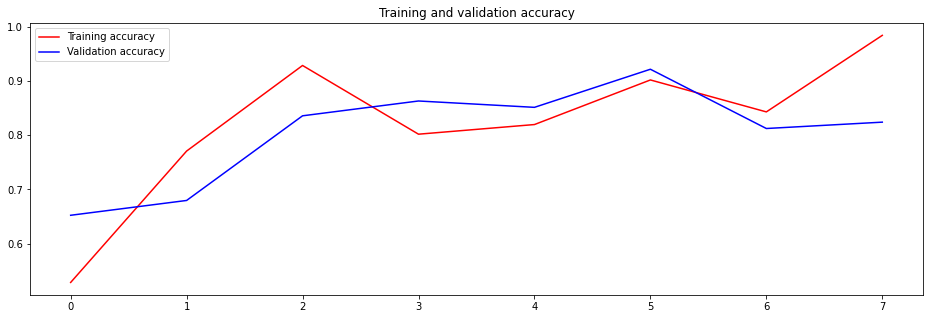

<Figure size 432x288 with 0 Axes>

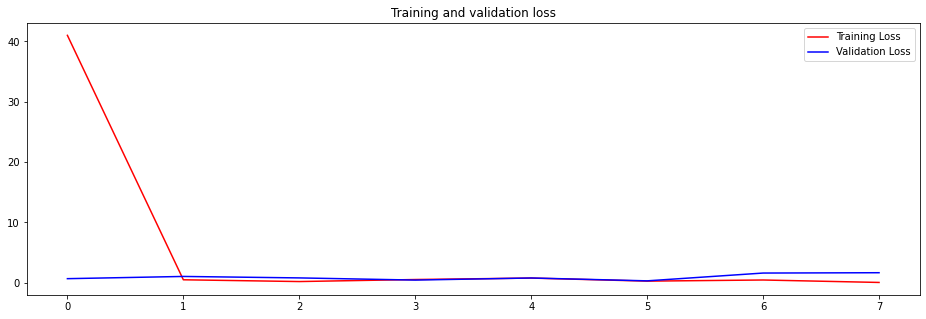

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(16, 5))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.figure(figsize=(16, 5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving caballo.jpg to caballo (1).jpg


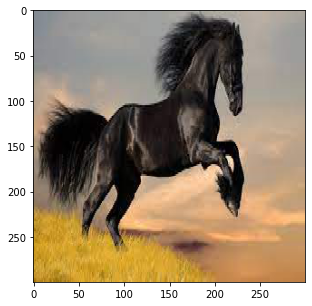

caballo.jpg is a horse


In [11]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()


for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn 
  img = image.load_img(path, target_size=(300, 300))
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  #print(classes[0])
  if classes[0]>0.5:
    print(fn+' is a human')
  else:
    print(fn+' is a horse')

In [12]:
import matplotlib.image as mpimg

# plotting the images of shape 5x5
n_rows = 5
n_columns = 5

# idx for iterating over the images
pic_ind = 0

fig = plt.gcf() # get current figure 
fig.set_size_inches(n_columns*5, n_rows*5)

# get the path for the figures
next_horse_pic = [os.path.join(train_horse_dir, fname) for fname in train_horse_names[pic_ind:pic_ind+10]]
next_human_pic = [os.path.join(train_human_dir, fname) for fname in train_human_names[pic_ind:pic_ind+10]]

for i, img_path in enumerate(next_horse_pic+next_human_pic):
  plt.subplot(n_rows, n_columns, i+1)
  plt.axis(False)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Output hidden; open in https://colab.research.google.com to view.